In [97]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from pprint import pprint
import nltk
from nltk.corpus import words, brown, gutenberg
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
DATA_FILE = "hamlet.txt"

In [4]:
RE_SCENE_HEADER = r"^\tHAMLET\n+ACT [A-Z]+\n+SCENE [A-Z]+\t.+\n+"
RE_DIALOG_HEADER = r"(?:\n\n+)[A-Z][A-Za-z ]+(?:\t)"
RE_EMPTY_LINE = r"^[\s|]*$"
RE_CHAR_NAME = r"(^[A-Z][A-Za-z ]+)(?:\t)"
RE_ACTIONS = r"\[([^\]]*\n)*[^\]]*\]"

In [159]:
def re_search_all(regex_pat: str, text: str) -> list:
    """Returns a list of all match objects"""
    return list( re.finditer(regex_pat, text, flags=re.MULTILINE) )

def re_split(regex_pat: str, text: str) -> list:
    """Custom regex split solution, re.split() either throw away the delimiter 
    or keep it as separate items, doesn't suit the needs here.
    """
    matches = re_search_all(regex_pat, text)
    split_positions = [m.start() for m in matches]
    
    if split_positions[0] > 0:  # add starting position if it's not there
        split_positions = [0] + split_positions
    split_positions = split_positions + [len(text)]  # add end position
    split_positions

    splits = []
    n_splits = len(split_positions) - 1
    for i in range(n_splits):
        splits.append(text[split_positions[i] : split_positions[i+1]])
    return splits

def get_scene_header(scene: str) -> str:
    return re.search(RE_SCENE_HEADER, scene, flags=re.MULTILINE).group(0)

def strip_scene_header(scene: str) -> str:
    return re.sub(RE_SCENE_HEADER, "", scene, flags=re.MULTILINE)

def get_scene_dialogs(scene: str) -> str:
    scene_body = strip_scene_header(scene)
    dialogs = re_split(RE_DIALOG_HEADER, scene_body)
    return dialogs

def get_dialog_lines(dialog: str) -> list: 
    dialog = re.sub(RE_ACTIONS, "", dialog, flags=re.MULTILINE)
    dialog = re.sub(RE_CHAR_NAME, "", dialog, flags=re.MULTILINE)
    lines = [line for line in re.split(r"\n", dialog)
             if not re.match(RE_EMPTY_LINE, line)]
    return lines

def get_character_lines(scenes: list) -> dict:
    char_lines_dict = {}
    for scene in scenes:
        dialogs = get_scene_dialogs(scene)
        for d in dialogs:
            chars = re.findall(RE_CHAR_NAME, d, flags=re.MULTILINE)
            lines = get_dialog_lines(d)
            for c in chars:
                if c in char_lines_dict:
                    char_lines_dict[c] = char_lines_dict[c] + lines
                else: 
                    char_lines_dict[c] = lines
    return char_lines_dict

def count_character_lines(char_lines_dict: dict) -> pd.Series:
    char_n_lines = {}
    for char in char_lines_dict:
        char_n_lines[char] = len(char_lines_dict[char])
    return pd.Series(char_n_lines)

def get_all_scripts(scenes: list):
    all_scenes_text = ''
    for scene in scenes:
        dialogs = get_scene_dialogs(scene)
        all_scenes_text = all_scenes_text + '\n'.join(dialogs)
    return all_scenes_text

def spacy_lemmatise(text: str) -> list:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha]
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    context = []
    for i in range(len(tokens)):
        i_start = i-5 if i>=5 else 0
        i_end = i+5 if i<=len(tokens)-5 else len(tokens)
        context.append(' '.join([t for t in tokens[i_start:i_end]]))
    lemma_map = pd.DataFrame({'token': tokens, 'lemma': lemmas, 'context': context}).drop_duplicates()
    return lemmas, lemma_map

def show_word_cloud(text: str):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    fig, ax = plt.subplots(figsize=(15,8))
    _ = plt.imshow(wordcloud, interpolation='bilinear')
    _ = plt.axis("off")

In [6]:
full_book = open(DATA_FILE).read()

In [7]:
scenes = re_split(RE_SCENE_HEADER, full_book)[1:]  # first item is "cast"

pd.Series(scenes)

0     \tHAMLET\n\n\nACT I\n\n\n\nSCENE I\tElsinore. ...
1     \tHAMLET\n\n\nACT I\n\n\n\nSCENE II\tA room of...
2     \tHAMLET\n\n\nACT I\n\n\n\nSCENE III\tA room i...
3     \tHAMLET\n\n\nACT I\n\n\n\nSCENE IV\tThe platf...
4     \tHAMLET\n\n\nACT I\n\n\n\nSCENE V\tAnother pa...
5     \tHAMLET\n\n\nACT II\n\n\n\nSCENE I\tA room in...
6     \tHAMLET\n\n\nACT II\n\n\n\nSCENE II\tA room i...
7     \tHAMLET\n\n\nACT III\n\n\n\nSCENE I\tA room i...
8     \tHAMLET\n\n\nACT III\n\n\n\nSCENE II\tA hall ...
9     \tHAMLET\n\n\nACT III\n\n\n\nSCENE III\tA room...
10    \tHAMLET\n\n\nACT III\n\n\n\nSCENE IV\tThe Que...
11    \tHAMLET\n\n\nACT IV\n\n\n\nSCENE I\tA room in...
12    \tHAMLET\n\n\nACT IV\n\n\n\nSCENE II\tAnother ...
13    \tHAMLET\n\n\nACT IV\n\n\n\nSCENE III\tAnother...
14    \tHAMLET\n\n\nACT IV\n\n\n\nSCENE IV\tA plain ...
15    \tHAMLET\n\n\nACT IV\n\n\nSCENE V\tElsinore. A...
16    \tHAMLET\n\n\nACT IV\n\n\n\nSCENE VI\tAnother ...
17    \tHAMLET\n\n\nACT IV\n\n\nSCENE VII\tAnoth

In [8]:
char_lines = get_character_lines(scenes)

char_lines['First Sailor']

['God bless you, sir.',
 "He shall, sir, an't please him. There's a letter for",
 '\tyou, sir; it comes from the ambassador that was',
 '\tbound for England; if your name be Horatio, as I am',
 '\tlet to know it is.']

In [171]:
# this version seems to be missing some lines?

char_num_of_lines = count_character_lines(char_lines)

char_num_of_lines.sort_values(ascending=False)

HAMLET               1148
KING CLAUDIUS         513
LORD POLONIUS         354
HORATIO               231
OPHELIA               168
LAERTES               153
QUEEN GERTRUDE        138
ROSENCRANTZ            96
Ghost                  95
MARCELLUS              67
GUILDENSTERN           52
First Player           52
First Clown            51
Player King            44
BERNARDO               38
Player Queen           30
Gentleman              24
VOLTIMAND              22
Second Clown           18
REYNALDO               15
Captain                12
FRANCISCO              10
PRINCE FORTINBRAS       8
LUCIANUS                6
First Sailor            5
Messenger               5
Prologue                3
Danes                   3
All                     2
CORNELIUS               1
Servant                 1
dtype: int64

In [158]:
all_scripts = get_all_scripts(scenes)  # all lines and actions excluding headers

print(all_scripts[:300])

	[FRANCISCO at his post. Enter to him BERNARDO]


BERNARDO	Who's there?


FRANCISCO	Nay, answer me: stand, and unfold yourself.


BERNARDO	Long live the king!


FRANCISCO	Bernardo?


BERNARDO	He.


FRANCISCO	You come most carefully upon your hour.


BERNARDO	'Tis now struck twelve; get thee to bed, 


In [160]:
# NLTK WordNet lemmatiser's result wasn't very good
# spacy is a bit better but still makes some mistakes
# should add some customised rules and stop words if time allows

tokens_lemmatised, lemma_map = spacy_lemmatise(all_scripts)

In [172]:
# lemma map is used to diagnose the preformance of lemmatiser
lemma_map.head()

,token,lemma,context
0,francisco,francisco,francisco at his post enter
1,at,at,francisco at his post enter to
2,his,-pron-,francisco at his post enter to him
3,post,post,francisco at his post enter to him bernardo
4,enter,enter,francisco at his post enter to him bernardo be...


In [162]:
# brown corpus was created in 1961, seems to be a good choice for older literature
common_english_words = pd.Series([w.lower() for w in brown.words()])\
                        [lambda s: s.str.isalpha()]\
                        .value_counts().head(10000).index.values.tolist()

common_english_words[:10]

['the', 'of', 'and', 'to', 'a', 'in', 'that', 'is', 'was', 'he']

In [173]:
# Sometimes characters are referred to without their title
char_names = list(char_lines.keys()) + ['CLAUDIUS', 'POLONIUS', 'GERTRUDE', 'FORTINBRAS']
char_names = [c.lower() for c in char_names]

# Convert to Series since list comprehension was too slow
# -pron- token is added by spacy
tokens_unusual = pd.Series(tokens_lemmatised)\
                [lambda s: ~s.isin(common_english_words + ['-pron-'] + char_names)]  

tokens_unusual.value_counts()

tis            63
hath           54
exit           36
exeunt         34
ay             33
clown          30
doth           25
nay            21
denmark        18
madness        18
sword          16
revenge        14
majesty        14
hast           14
norway         12
oft            11
re             11
ho             11
villain        11
offence        11
madam          10
foul           10
ere            10
honour          9
ha              9
twere           9
pyrrhus         9
fare            8
dost            8
thine           8
               ..
spendthrift     1
parch           1
pitiful         1
winks           1
riband          1
hugger          1
rhapsody        1
seneca          1
musty           1
dido            1
calumnious      1
individable     1
purposed        1
unkennel        1
snuff           1
canker          1
beauteous       1
ild             1
polacks         1
enviously       1
commendable     1
wrung           1
paddle          1
bulwark         1
bisson    

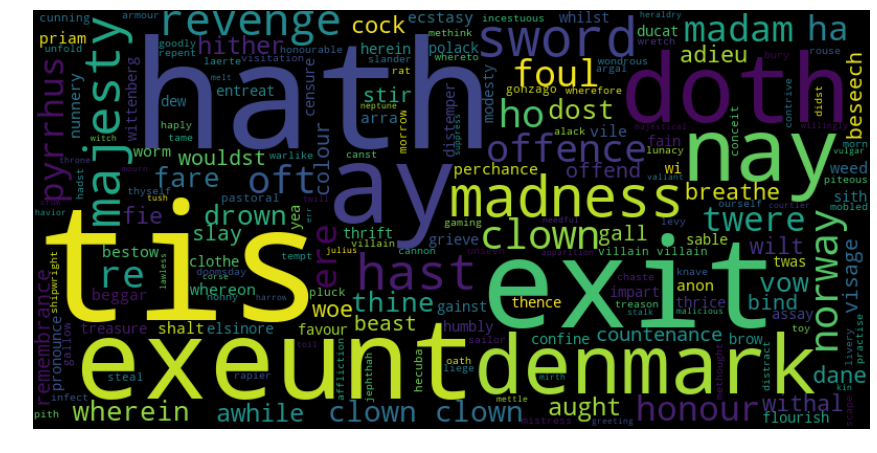

In [174]:
show_word_cloud(' '.join(tokens_unusual))